# Part 3: Expanding on our budget optimization through cluster analysis
In this section we will:

Run data through cluster analysis and how it can be used in sports analytics, 
Pitching and fielding data, 
Use machine learning to cluster players, and 
Expand on identifing undervalued players who we could replace our current players with (because they're aging out, are too expensive, are leaving, etc.)

This below code is for us to prepare our envioronment

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import ipywidgets as widgets
from IPython.display import clear_output
from ipywidgets import IntSlider, Output

# Disable numexpr for all eval/query
pd.set_option("compute.use_numexpr", False)

# Rename columns to be more descriptive
abbrev_map = {
    # General
    "W": "Wins",
    "L": "Losses",
    "G": "Games",
    "GS": "GamesStarted",

    # Batting
    "R": "Runs",

    "AB": "AtBats",

    "H": "Hits",
    "2B": "Doubles",
    "3B": "Triples",
    "HR": "HomeRuns",

    "BB": "Walks",
    "HBP": "HitsByPitch",
    "SF": "SacrificeFlies",

    # Fielding
    "PO": "Putouts",
    "A": "Assists",
    "E": "Errors",
    "DP": "DoublePlays",
    "POS": "Position",

    "PB": "PassedBalls",
    "WP": "WildPitch",
    "SB": "StolenBasesAllowed",
    "CS": "CaughtStealing",
    "ZR": "ZoneRating",

    # Additional
    "CG": "CompleteGames",
    "SHO": "Shutouts",
    "SV": "Saves",
    "IPouts": "OutsPitched",
    "ER": "EarnedRuns",
    "SO": "Strikeouts",
    "BAOpp": "OpponentsBattingAverage",
    "ERA": "EarnedRunAverage",
    "IBB": "IntentionalWalks",
    "BK": "Balks",
    "BFP": "BattersFacedByPitcher",
    "GF": "GamesFinished",
    "SH": "SacrificeHits",
    "SF": "SacrificeFlies",
    "GIDP": "GroundedIntoDoublePlay"
}

def process(df):
  df = df.loc[df["yearID"] > 1972]
  df = df.rename(columns=abbrev_map)

  return df

# BATTING
batting = pd.read_csv("https://drive.google.com/uc?id=17IM9kxyscGEpu-4Ov5p7MpCKz9UVHLla")
batting = process(batting)
batting = batting.loc[batting["AtBats"] > 130] 
batting = batting.drop(columns=['teamID', 'lgID'])

# FIELDING
fielding = pd.read_csv("https://drive.google.com/uc?id=1Vhh5hMTWmgHTQ7lLUL1ugWNIeHIt4Mev")
fielding = process(fielding)
fielding = fielding.drop(columns=['WildPitch', 'GamesStarted', 'CaughtStealing', 'InnOuts', 'teamID', 'lgID']) 

# PITCHING
pitching = pd.read_csv("https://drive.google.com/uc?id=11QmRiKddAVeSt6gCtW-5r0Qp_bFnxOVb")
pitching = process(pitching)
pitching = pitching.drop(columns=['WildPitch', 'GamesStarted', 'Wins', 'Losses', 'BattersFacedByPitcher', 'teamID', 'lgID']) 

## Milestone 1: Importance of Cluster Analysis in Data Analytics

Clustering facilitates the exploration of large and complex datasets by summarizing the data into meaningful groups.

Feature Engineering: Clustering can be used for creating new features based on cluster assignments. These engineered features can improve models by capturing structures and relationships in the data.

Anomaly Detection: Clustering can also be utilized for anomaly detection by identifying data points that do not conform to the typical patterns observed in the data. Anomalies may represent unusual events, outliers, or errors that require further investigation.

How Cluster Analysis Can Apply to Sports
In sports analytics, clustering analysis holds particular significance due to its ability to uncover insights and patterns within player performance, team dynamics, and game strategies:

Player/Team Comparison: Clustering enables comparisons between players or teams based on their characteristics, performance metrics, playing styles, etc. By clustering players or teams into meaningful groups, analysts can identify similarities, differences, strengths, and weaknesses, aiding coaches, managers, and analysts in strategic decision-making. This is what you'll be doing in this notebook!

Player Development: Clustering can also aid in player development efforts by identifying players with similar skill sets or playing styles. Coaches and talent scouts can use clustering insights to personalize training programs, match players with compatible teammates, or identify potential recruits based on desired characteristics.

Fan Engagement: Clustering analysis can be applied to fan segmentation, allowing sports organizations to understand fan preferences, behaviors, and engagement levels.



## Milestone 2: Introducing the fielding and pitching datasets
Fielding Statistics
These new statistics allows us to explore the defensive side of baseball effectively.

We'll start with the following columns: playerID, yearID, Positions, and key defensive metrics such as Putouts, Assists, Errors, DoublePlays, StolenBasesAllowed, and ZoneRating. These statistics offer a well-rounded picture of how players contribute defensively.

In [3]:
fielding.sample(5)

,playerID,yearID,stint,Position,Games,Putouts,Assists,Errors,DoublePlays,PassedBalls,StolenBasesAllowed,ZoneRating
79256,babcobo01,1981,1,P,16,2,4,0.0,0,NaN,NaN,NaN
92660,benavfr01,1991,1,2B,3,7,4,0.0,1,NaN,NaN,NaN
122011,velazgi01,2008,1,2B,2,5,9,0.0,2,NaN,NaN,NaN
99887,alexama02,1996,1,OF,3,2,1,1.0,0,NaN,NaN,NaN
104514,smithma03,1998,1,1B,6,30,4,0.0,3,NaN,NaN,NaN


#### One-Hot Encoding Player Positions
We will now convert the Position column in fielding to a numerical format using one-hot encoding. This will allow us to include player positions in our machine learning models, enabling more robust analysis.

In [4]:
fielding = pd.get_dummies(fielding, columns=['Position'])
fielding.sample(5)

,playerID,yearID,stint,Games,Putouts,Assists,Errors,DoublePlays,PassedBalls,StolenBasesAllowed,ZoneRating,Position_1B,Position_2B,Position_3B,Position_C,Position_OF,Position_P,Position_SS
119967,romerjc01,2007,1,23,2,3,1.0,0,NaN,NaN,NaN,False,False,False,False,False,True,False
121268,larocad01,2008,1,129,1130,81,8.0,121,NaN,NaN,NaN,True,False,False,False,False,False,False
84970,lyonsst01,1985,1,1,0,0,0.0,0,NaN,NaN,NaN,False,False,False,False,False,False,True
137735,iannech01,2017,1,1,0,0,0.0,0,NaN,NaN,NaN,False,False,True,False,False,False,False
88547,curryst01,1988,1,3,0,3,0.0,0,NaN,NaN,NaN,False,False,False,False,False,True,False


#### Pitching Statistics

Featured Metrics
Earned Run Average (ERA): The average number of earned runs a pitcher allows per nine innings, a primary indicator of pitching effectiveness.
Strikeouts (SO): Reflects the number of batters a pitcher retires by strikeout, showcasing their ability to overpower hitters.
Saves (SV): Important for relief pitchers, this metric indicates how often a pitcher successfully preserves a lead, securing a win.
Complete Games (CG): Shows the number of games a pitcher pitches from start to finish, highlighting durability and stamina.
Opponents Batting Average (BAOpp): The batting average of opposing hitters, providing insights into a pitcher's ability to limit hits.

By focusing on these key statistics, we can unravel the complexities of pitching in baseball, assessing how individual pitchers contribute to their teams' defensive efforts.

In [5]:
pitching.sample(5)

,playerID,yearID,stint,Games,CompleteGames,Shutouts,Saves,OutsPitched,Hits,EarnedRuns,...,OpponentsBattingAverage,EarnedRunAverage,IntentionalWalks,HitsByPitch,Balks,GamesFinished,Runs,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlay
32279,anderma01,1999,1,37,0,0,0,114,33,24,...,0.232,5.68,1.0,1.0,0,9,27,0.0,2.0,2.0
31176,darwida01,1997,2,10,0,0,0,132,51,24,...,0.288,4.91,0.0,1.0,0,0,26,3.0,1.0,3.0
28127,meachru01,1991,1,10,0,0,0,83,35,16,...,0.315,5.20,0.0,0.0,1,1,17,1.0,3.0,2.0
35390,ritchto01,2003,1,5,0,0,0,85,36,16,...,0.319,5.08,0.0,4.0,0,0,17,2.0,2.0,3.0
24770,lahtije01,1984,1,63,0,0,1,254,69,35,...,0.225,3.72,12.0,2.0,0,19,36,7.0,3.0,7.0


## Milestone 3: More Processing!
Handling Multiple Stints
Sometimes players play on different teams in a given year! In order to summarize a given player's performance per year, we will alter our dataframe to have just one number per metric per playerID, yearID combination. We will write the code in the cell below to do this.

In [6]:
batting = batting.groupby(['playerID', 'yearID']).sum(numeric_only=True)
batting = batting.drop(columns=['stint'])
batting = batting.reset_index()

fielding = fielding.groupby(['playerID', 'yearID']).sum(numeric_only=True)
fielding = fielding.drop(columns=['stint'])
fielding = fielding.reset_index()

pitching = pitching.groupby(['playerID', 'yearID']).sum(numeric_only=True)
pitching = pitching.drop(columns=['stint'])
pitching = pitching.reset_index()

#### Normalizing by Number of Games
Since we're comparing players no matter the situation in a given season, we need to make sure we're comparing them fairly. Just as we did with the WinningPercentage in the first notebook, here we need to normalize all of the columns by the number of games each player has played in a given season.

However, some statistics correspond to rates and it won't make sense to normalize those by the number of games. 

In [7]:
battingRateStatistics = pd.DataFrame({"playerID": batting["playerID"],
                                      "yearID": batting["yearID"],
                                      "BattingAverage": batting.eval("Hits / AtBats"),
                                      "OnBasePercentage": batting.eval("(Hits + Walks + HitsByPitch) / (AtBats + Walks + HitsByPitch + SacrificeFlies)"),
                                      "SluggingPercentage": batting.eval("(Hits + Doubles + 2*Triples + 3*HomeRuns) / AtBats")})

pitchingRateStatistics = pitching[["playerID", "yearID", "OpponentsBattingAverage"]]
pitching = pitching.drop(columns=["OpponentsBattingAverage"])

fieldingRateStatistics = fielding[["playerID", "yearID", "ZoneRating", "Position_1B", "Position_2B", "Position_3B", "Position_C", "Position_OF", "Position_P", "Position_SS"]]
fielding = fielding.drop(columns=["ZoneRating", "Position_1B", "Position_2B", "Position_3B", "Position_C", "Position_OF", "Position_P", "Position_SS"])

Now that we've saved those rate statistics to the side, we can use the .div() method to divide all of our columns by another.

In [8]:
batting_normalized = batting.drop(columns=['playerID']).div(batting['Games'], axis=0)
batting_normalized = batting_normalized.drop(columns=['Games'])
batting_normalized[['playerID', 'yearID']] = batting[['playerID', 'yearID']]

fielding_normalized = fielding.drop(columns=['playerID']).div(fielding['Games'], axis=0)
fielding_normalized = fielding_normalized.drop(columns=['Games'])
fielding_normalized[['playerID', 'yearID']] = fielding[['playerID', 'yearID']]

pitching_normalized = pitching.drop(columns=['playerID']).div(pitching['Games'], axis=0)
pitching_normalized = pitching_normalized.drop(columns=['Games'])
pitching_normalized[['playerID', 'yearID']] = pitching[['playerID', 'yearID']]

batting_normalized

,yearID,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,RBI,StolenBasesAllowed,CaughtStealing,Walks,Strikeouts,IntentionalWalks,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlay,playerID
0,1973,3.266667,0.700000,0.983333,0.100000,0.008333,0.333333,0.800000,0.008333,0.008333,0.566667,0.425000,0.108333,0.008333,0.000000,0.033333,0.058333,aaronha01
1,1974,3.035714,0.419643,0.812500,0.142857,0.000000,0.178571,0.616071,0.008929,0.000000,0.348214,0.258929,0.053571,0.000000,0.008929,0.017857,0.053571,aaronha01
2,1975,3.394161,0.328467,0.795620,0.116788,0.014599,0.087591,0.437956,0.000000,0.007299,0.510949,0.372263,0.021898,0.007299,0.007299,0.043796,0.109489,aaronha01
3,1976,3.188235,0.258824,0.729412,0.094118,0.000000,0.117647,0.411765,0.000000,0.011765,0.411765,0.447059,0.011765,0.000000,0.000000,0.023529,0.094118,aaronha01
4,1998,2.741573,0.370787,0.764045,0.157303,0.011236,0.134831,0.460674,0.033708,0.033708,0.101124,0.314607,0.011236,0.000000,0.022472,0.056180,0.022472,abbotje01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17812,2019,2.955556,0.333333,0.488889,0.111111,0.011111,0.100000,0.355556,0.000000,0.000000,0.222222,1.088889,0.000000,0.033333,0.000000,0.000000,0.044444,zuninmi01
17813,2021,3.055046,0.587156,0.660550,0.100917,0.018349,0.302752,0.568807,0.000000,0.000000,0.311927,1.211009,0.000000,0.064220,0.000000,0.009174,0.064220,zuninmi01
17814,1992,3.161290,0.370968,0.870968,0.153226,0.008065,0.024194,0.346774,0.016129,0.016129,0.201613,0.483871,0.008065,0.032258,0.056452,0.032258,0.048387,zupcibo01
17815,1993,2.028369,0.283688,0.489362,0.170213,0.014184,0.014184,0.184397,0.035461,0.014184,0.191489,0.382979,0.014184,0.014184,0.056738,0.021277,0.049645,zupcibo01


#### Merging
Since we eventually want to have a complete view of each player, including their batting, fielding, and pitching statistics, we need to make a new table that includes all this info.

In our case, we want to use an outer join instead, which will include every 'playerID', 'yearID' combination, and pull data that matches these combinations from those dataframes. If the combination isn't found in a given dataframe, then the merging will place in NaN values for the corresponding columns. 

In the code cell below we will merge all three datasets.

In [9]:
merged = pd.merge(pitching_normalized, batting_normalized, on=['playerID', 'yearID'], how='outer', suffixes=['AsPitcher', 'AsBatter'])
merged = pd.merge(merged, fielding_normalized, on=['playerID', 'yearID'], how='outer', suffixes=['AsBatter', 'AsFielder'])
merged.head()

,yearID,CompleteGames,Shutouts,Saves,OutsPitched,HitsAsPitcher,EarnedRuns,HomeRunsAsPitcher,WalksAsPitcher,StrikeoutsAsPitcher,...,HitsByPitchAsBatter,SacrificeHitsAsBatter,SacrificeFliesAsBatter,GroundedIntoDoublePlayAsBatter,Putouts,Assists,Errors,DoublePlays,PassedBalls,StolenBasesAllowedAsFielder
0,2004,0.0,0.0,0.000000,2.909091,1.818182,0.727273,0.090909,0.909091,0.454545,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,0.000000,0.0,0.0
1,2006,0.0,0.0,0.000000,3.533333,0.911111,0.533333,0.200000,0.622222,1.088889,...,NaN,NaN,NaN,NaN,0.022222,0.111111,0.00,0.022222,0.0,0.0
2,2007,0.0,0.0,0.000000,3.880000,1.560000,0.920000,0.160000,0.680000,1.440000,...,NaN,NaN,NaN,NaN,0.080000,0.160000,0.04,0.000000,0.0,0.0
3,2008,0.0,0.0,0.000000,3.106383,1.042553,0.638298,0.085106,0.744681,1.042553,...,NaN,NaN,NaN,NaN,0.063830,0.127660,0.00,0.000000,0.0,0.0
4,2009,0.0,0.0,0.520548,2.931507,0.671233,0.273973,0.054795,0.465753,1.095890,...,NaN,NaN,NaN,NaN,0.027397,0.068493,0.00,0.013699,0.0,0.0


In [10]:
merged = pd.merge(merged, battingRateStatistics, on=['playerID', 'yearID'], how='outer')
merged = pd.merge(merged, pitchingRateStatistics, on=['playerID', 'yearID'], how='outer')
merged = pd.merge(merged, fieldingRateStatistics, on=['playerID', 'yearID'], how='outer')

### Getting one set of values per player
Since players potentially play for multiple years, we want to have some way of having one set of values to describe a particular player.

#### Analyzing Players' Most Recent Performance
In this approach, we aim to concentrate on the latest performance metrics of the players. This is useful for players who are falling out of their prime or recently had a breakout season.

To implement this strategy, we will identify and extract the rows corresponding to each player's most recent year of play. This requires two steps in our code:

Selecting Rows Based on Identified Indices: With the indices of the most recent year for each player obtained, we then use .loc[] to select these specific rows from our DataFrame.

This process filters our dataset to only include the latest available statistics for each player. It effectively simplifies the dataset, making it more manageable and focused on current performance levels.


In [12]:
playersMostRecentYearIndices = merged.groupby('playerID')['yearID'].idxmax()
merged = merged.loc[playersMostRecentYearIndices]
merged.sample(5)

,yearID,CompleteGames,Shutouts,Saves,OutsPitched,HitsAsPitcher,EarnedRuns,HomeRunsAsPitcher,WalksAsPitcher,StrikeoutsAsPitcher,...,SluggingPercentage,OpponentsBattingAverage,ZoneRating,Position_1B,Position_2B,Position_3B,Position_C,Position_OF,Position_P,Position_SS
39361,1983,0.1,0.033333,0.00,18.633333,7.133333,3.200000,0.800000,1.633333,2.733333,...,NaN,0.578,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
23520,1996,0.0,0.000000,0.04,2.040000,0.760000,0.480000,0.040000,0.240000,0.200000,...,NaN,0.284,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28086,2022,0.0,0.000000,0.00,16.413793,4.655172,2.241379,0.931034,2.034483,5.413793,...,NaN,0.228,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
480,2022,0.0,0.000000,0.00,3.300000,1.000000,0.500000,0.200000,0.300000,0.100000,...,0.365385,0.238,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1555,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Getting rid of missing data

Now we have the dataset we can work with! Unfortunately, though, our nearest neighbors model will not be able to work with those NaNs.



In [13]:
merged = merged.fillna(0)

#### Focus on recent players
Now that we've merged our datasets, we may want to focus only on those players that have played recently, since they would be the best options to replace a player on our team.


In [15]:
merged = merged[merged['yearID'] >= 2019]
merged = merged.reset_index()
merged.sample(5)

,level_0,index,yearID,CompleteGames,Shutouts,Saves,OutsPitched,HitsAsPitcher,EarnedRuns,HomeRunsAsPitcher,...,SluggingPercentage,OpponentsBattingAverage,ZoneRating,Position_1B,Position_2B,Position_3B,Position_C,Position_OF,Position_P,Position_SS
1916,1916,47386,2022,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.464567,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1554,1554,38689,2022,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.521053,0.000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
311,311,7624,2022,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.315789,0.000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
975,975,23751,2022,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
893,893,21719,2022,0.0,0.0,0.351852,3.592593,0.518519,0.166667,0.111111,...,0.000000,0.128,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Scaling the data
Before moving on from data processing to cluster analysis, we need to make sure our data is scaled! Cluster analysis relies on calculating distances between different data points, so we want to make sure all of our features are on the same scale.

In [16]:
merged.describe()

,level_0,index,yearID,CompleteGames,Shutouts,Saves,OutsPitched,HitsAsPitcher,EarnedRuns,HomeRunsAsPitcher,...,SluggingPercentage,OpponentsBattingAverage,ZoneRating,Position_1B,Position_2B,Position_3B,Position_C,Position_OF,Position_P,Position_SS
count,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,...,2286.000000,2286.000000,2286.0,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000,2286.000000
mean,1142.500000,28142.916448,2021.375766,0.001012,0.000384,0.014867,3.798172,1.351044,0.765562,0.213427,...,0.079979,0.185024,0.0,0.135608,0.126859,0.127734,0.087489,0.249781,0.682415,0.086614
std,660.055679,16428.873376,0.996321,0.013150,0.004714,0.061089,4.854585,1.759255,1.093770,0.358729,...,0.159937,0.188313,0.0,0.387982,0.369049,0.362765,0.314842,0.489887,0.612572,0.302325
min,0.000000,37.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,571.250000,13983.500000,2021.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1142.500000,28150.500000,2022.000000,0.000000,0.000000,0.000000,2.809017,0.800000,0.344545,0.026671,...,0.000000,0.208500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1713.750000,42942.750000,2022.000000,0.000000,0.000000,0.000000,4.329167,1.906046,1.057143,0.277778,...,0.000000,0.286000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2285.000000,56115.000000,2022.000000,0.500000,0.111111,0.660000,21.437500,12.000000,10.000000,3.500000,...,0.685965,1.167000,0.0,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,3.000000


We can use sklearn's StandardScaler! This will basically scale the data so that it all has the same average and spread.

In [20]:
merged = merged.reset_index()
merged = merged.set_index("playerID")

scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged)

pd.DataFrame(scaled_data, columns=merged.columns).describe()

,level_0,index,yearID,CompleteGames,Shutouts,Saves,OutsPitched,HitsAsPitcher,EarnedRuns,HomeRunsAsPitcher,...,SluggingPercentage,OpponentsBattingAverage,ZoneRating,Position_1B,Position_2B,Position_3B,Position_C,Position_OF,Position_P,Position_SS
count,2286.000000,2286.000000,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,...,2.286000e+03,2.286000e+03,2286.0,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03,2.286000e+03
mean,0.000000,0.000000,-2.833973e-14,-1.398706e-17,7.770590e-19,4.351530e-17,2.642001e-17,-3.108236e-17,9.247002e-17,8.858472e-17,...,6.605001e-17,-2.020353e-17,0.0,5.439413e-18,2.797412e-17,-7.770590e-19,-2.797412e-17,-1.554118e-17,-1.476412e-17,-1.864942e-17
std,1.000219,1.000219,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,...,1.000219e+00,1.000219e+00,0.0,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00,1.000219e+00
min,-1.731293,-1.711138,-2.385060e+00,-7.697953e-02,-8.148751e-02,-2.434165e-01,-7.825597e-01,-7.681316e-01,-7.000826e-01,-5.950823e-01,...,-5.001723e-01,-9.827458e-01,0.0,-3.495978e-01,-3.438211e-01,-3.521898e-01,-2.779430e-01,-5.099871e-01,-1.114260e+00,-2.865559e-01
25%,-0.865647,-0.862050,-3.772356e-01,-7.697953e-02,-8.148751e-02,-2.434165e-01,-7.825597e-01,-7.681316e-01,-7.000826e-01,-5.950823e-01,...,-5.001723e-01,-9.827458e-01,0.0,-3.495978e-01,-3.438211e-01,-3.521898e-01,-2.779430e-01,-5.099871e-01,-1.114260e+00,-2.865559e-01
50%,0.000000,0.000462,6.266767e-01,-7.697953e-02,-8.148751e-02,-2.434165e-01,-2.038013e-01,-3.132943e-01,-3.850068e-01,-5.207162e-01,...,-5.001723e-01,1.246939e-01,0.0,-3.495978e-01,-3.438211e-01,-3.521898e-01,-2.779430e-01,-5.099871e-01,5.185593e-01,-2.865559e-01
75%,0.865647,0.901040,6.266767e-01,-7.697953e-02,-8.148751e-02,-2.434165e-01,1.094041e-01,3.155443e-01,2.666422e-01,1.794261e-01,...,-5.001723e-01,5.363321e-01,0.0,-3.495978e-01,-3.438211e-01,-3.521898e-01,-2.779430e-01,-5.099871e-01,5.185593e-01,-2.865559e-01
max,1.731293,1.702990,6.266767e-01,3.795554e+01,2.349440e+01,1.056286e+01,3.634335e+00,6.054428e+00,8.444611e+00,9.163723e+00,...,3.789728e+00,5.215730e+00,0.0,9.962409e+00,1.049721e+01,7.919447e+00,9.252721e+00,5.615217e+00,5.417016e+00,9.638700e+00


## Milestone 4: Cluster Analysis!

Now that we've finished that daya processing, we've now coded to find the most similar players based on a K Nearest Neighbors model!



In [29]:
chosen_player_id_widget = widgets.Dropdown(options=merged.index, value='abbotco01', description='Player ID:')
number_of_neighbors_widget = widgets.IntSlider(value=5, min=1, max=20, step=1, description='# of Neighbors:')

features = merged.columns
first_feature_widget = widgets.Dropdown(options=features, value='OnBasePercentage', description='First Feature:')
second_feature_widget = widgets.Dropdown(options=features, value='BattingAverage', description='Second Feature:')

out = Output()

# Define a function to execute when the user clicks the button
def on_button_clicked(b):
    global merged
    out.clear_output()
    # Check if playerID column exists and set it as index for easy searching
    if "playerID" in merged.columns:
        merged = merged.set_index("playerID")

    chosen_player_id = chosen_player_id_widget.value
    number_of_neighbors = number_of_neighbors_widget.value
    first_feature_to_compare = first_feature_widget.value
    second_feature_to_compare = second_feature_widget.value

    chosen_player_stats = merged.loc[chosen_player_id]
    target_player_features = scaler.transform(
    chosen_player_stats.to_numpy().reshape(1, -1)
    )

    

    # Fit the KNN model
    nbrs = NearestNeighbors(n_neighbors=number_of_neighbors)
    nbrs.fit(scaled_data)

    target_player_features = scaler.transform(
    chosen_player_stats.to_numpy().reshape(1, -1)
    )

    # Find the nearest neighbors of the target player
    neighbors_indices = nbrs.kneighbors(
    target_player_features,
    return_distance=False
    )

    nearest_neighbors = merged.iloc[neighbors_indices[0]]

    with out:
      display(nearest_neighbors)

      # Visualization
      plt.figure(figsize=(10, 6))

      sns.scatterplot(data=merged.reset_index(), x=first_feature_to_compare, y=second_feature_to_compare, s=100, color='gray', alpha=0.5, label='Other Players')

      sns.scatterplot(data=nearest_neighbors.reset_index(), x=first_feature_to_compare, y=second_feature_to_compare, s=150, color='blue', label='Nearest Neighbors')

      plt.scatter(chosen_player_stats[first_feature_to_compare], chosen_player_stats[second_feature_to_compare], color='red', s=200, label='Chosen Player')

      # Label the points with player IDs
      for idx, row in nearest_neighbors.iterrows():
          plt.text(row[first_feature_to_compare], row[second_feature_to_compare], idx, horizontalalignment='right')
      plt.text(chosen_player_stats[first_feature_to_compare], chosen_player_stats[second_feature_to_compare], chosen_player_id, horizontalalignment='right', color='black')

      plt.title('Nearest Neighbors in Feature Space')
      plt.xlabel(first_feature_to_compare)
      plt.ylabel(second_feature_to_compare)
      plt.legend()
      plt.show()

button = widgets.Button(description='Find Neighbors')

button.on_click(on_button_clicked)

display(chosen_player_id_widget, number_of_neighbors_widget, first_feature_widget, second_feature_widget, button)

display(out)


Dropdown(description='Player ID:', index=1, options=('abadfe01', 'abbotco01', 'abramcj01', 'abreual01', 'abreu…

IntSlider(value=5, description='# of Neighbors:', max=20, min=1)

Dropdown(description='First Feature:', index=44, options=('level_0', 'index', 'yearID', 'CompleteGames', 'Shut…

Dropdown(description='Second Feature:', index=43, options=('level_0', 'index', 'yearID', 'CompleteGames', 'Shu…

Button(description='Find Neighbors', style=ButtonStyle())

Output()

### PCA Projection

Now, we will take a step back and visualize the full player dataset using a technique called Principal Component Analysis (PCA).

PCA helps us reduce the many player stats we’ve collected into just two dimensions, so we can see how players are distributed in space based on their overall performance. Each point on the plot represents a player, and players that are close together tend to have similar stat profiles.

This visualization can help us spot natural groupings, outliers, or unusual patterns in the data before we build any models. It's also a great way to get a high-level view of the structure of our dataset.

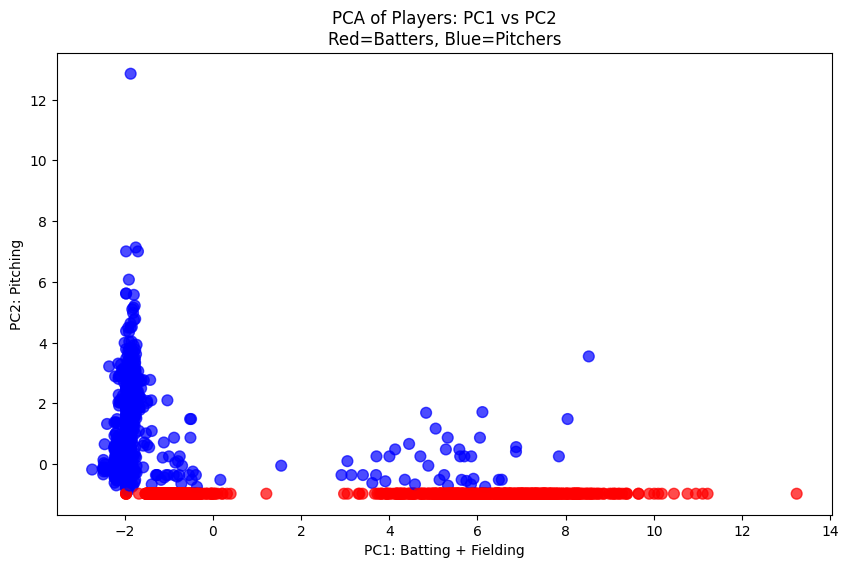

In [62]:
import matplotlib.pyplot as plt
import mplcursors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


batting_cols = [col for col in merged.columns if 'AsBatter' in col or col in ['BattingAverage','OnBasePercentage','SluggingPercentage','HomeRuns']]
fielding_cols = [col for col in merged.columns if 'Position_' in col or col in ['Putouts','Assists','Errors','ZoneRating']]
pitching_cols = ['EarnedRuns','StrikeoutsAsPitcher','Saves','CompleteGames']


pc1_data = merged[batting_cols + fielding_cols]
pc2_data = merged[pitching_cols]

scaled_pc1 = StandardScaler().fit_transform(pc1_data)
scaled_pc2 = StandardScaler().fit_transform(pc2_data)


pca_pc1 = PCA(n_components=1)
pca_pc1_values = pca_pc1.fit_transform(scaled_pc1)

pca_pc2 = PCA(n_components=1)
pca_pc2_values = pca_pc2.fit_transform(scaled_pc2)

# Combine into a single DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1_Batting_Fielding': pca_pc1_values.flatten(),
    'PC2_Pitching': pca_pc2_values.flatten()
}, index=merged.index)


is_pitcher = (merged[pitching_cols].sum(axis=1) > 0).values
colors = np.where(is_pitcher, 'blue', 'red')  # Pitchers = blue, Batters = red


plt.figure(figsize=(10,6))
scatter = plt.scatter(pca_df['PC1_Batting_Fielding'], pca_df['PC2_Pitching'], c=colors, s=60, alpha=0.7)
plt.xlabel('PC1: Batting + Fielding')
plt.ylabel('PC2: Pitching')
plt.title('PCA of Players: PC1 vs PC2\nRed=Batters, Blue=Pitchers')

cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(pca_df.index[sel.index]))

plt.show()


